In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.

['corpus_txt\\Doyle_AScandalinBohemia.txt',
 'corpus_txt\\Doyle_AStudyinScarlet.txt',
 'corpus_txt\\Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt\\Doyle_TheSignoftheFour.txt',
 'corpus_txt\\Howard_GodsoftheNorth.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [3]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

['Doyle_AScandalinBohemia',
 'Doyle_AStudyinScarlet',
 'Doyle_TheHoundoftheBaskervilles',
 'Doyle_TheSignoftheFour',
 'Howard_GodsoftheNorth']

#### Corpus laden

In [4]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [5]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

#### Create Dictionaries

In [6]:
id_types, doc_ids = pre.create_dictionaries(doc_labels, doc_tokens)

#### Sparse BOW Model

In [7]:
sparse_bow = pre.create_mm(doc_labels, doc_tokens, id_types, doc_ids)

In [8]:
sparse_bow[:5]

0
doc_id token_id   
1      20481     1
       16387     1
       4101      1
       16390     1
       6828      1

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [9]:
pre.save_bow_mm(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [10]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [11]:
mm = MmCorpus("gensim_txt.mm")

In [12]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [13]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [14]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

In [15]:
len(features_to_be_removed)

75

In [16]:
pre.save_bow_mm(sparse_bow_short, "gensim_txt")

In [17]:
mm = MmCorpus("gensim_txt.mm")

#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [18]:
doc2bow_list = pre.make_doc2bow_list(sparse_bow_short)

In [19]:
len(doc2bow_list)

17

In [20]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

In [21]:
model.get_document_topics(doc2bow_list[1])

[(1, 0.099701380871973111),
 (3, 0.34160856535720802),
 (7, 0.08240834277816704),
 (9, 0.06935708236023308),
 (11, 0.10560023781828309),
 (13, 0.019423207042390294),
 (14, 0.10513033434185065),
 (15, 0.028285443097552158),
 (17, 0.1308850359869547)]

In [22]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['alexandra',
 'prevalence',
 'honorably',
 'black-haired',
 'hewed',
 'angrily',
 'penitence',
 're',
 'flora',
 'tongues']

In [23]:
#Topic probabilities
topics = model.show_topics(num_topics = 40)
topics

[(0,
  '0.005*"canting" + 0.004*"encrustation" + 0.004*"planked" + 0.003*"alexandra" + 0.003*"prevalence" + 0.003*"she-elephant" + 0.003*"subconscious" + 0.003*"tongues" + 0.003*"bared" + 0.003*"gloom"'),
 (1,
  '0.009*"alexandra" + 0.006*"prevalence" + 0.006*"honorably" + 0.005*"black-haired" + 0.005*"hewed" + 0.005*"angrily" + 0.004*"penitence" + 0.004*"re" + 0.004*"flora" + 0.004*"tongues"'),
 (2,
  '0.000*"tumble-down" + 0.000*"beholding" + 0.000*"rustics" + 0.000*"speedily" + 0.000*"den" + 0.000*"countenance" + 0.000*"whitmarsh" + 0.000*"encrustation" + 0.000*"survived" + 0.000*"impinge"'),
 (3,
  '0.006*"igneous" + 0.004*"survived" + 0.004*"drums" + 0.004*"foes" + 0.003*"stared" + 0.003*"impinge" + 0.003*"rustics" + 0.003*"wails" + 0.003*"soar" + 0.003*"honorably"'),
 (4,
  '0.001*"mountainous" + 0.001*"alexandra" + 0.001*"flora" + 0.000*"honorably" + 0.000*"beholding" + 0.000*"re" + 0.000*"prevalence" + 0.000*"encrustation" + 0.000*"starker" + 0.000*"queerly"'),
 (5,
  '0.002*"s

In [24]:
import pandas as pd
import regex as re
def gensim2dataframe(model):
    num_topics = model.num_topics
    topics_df = pd.DataFrame(index = range(num_topics), columns= range(10))

    topics = model.show_topics(num_topics)
    
    for topic_dist in topics:    
        idx = topic_dist[0]
        temp = re.findall(r'\"(.+?)\"', topics[idx][1])
        topics_df.loc[idx] = temp
    
    return topics_df

In [25]:
topics_df = gensim2dataframe(model)

In [26]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,canting,alexandra,tumble-down,igneous,mountainous,strengthens,encrustation,speedily,my-cup,strangling,absentee,artistically,beholding,vulgar,claw,pithy,survived,fitted,stay-maker,den
1,encrustation,prevalence,beholding,survived,alexandra,scratched,alexandra,picket-pin,spear,friendliness,encrustation,bouguereau,survived,kings,selden's,frequency,stay-maker,alexandra,crumpled,beholding
2,planked,honorably,rustics,drums,flora,they'd,honorably,badge,function,beholding,pithy,bad,den,precipitous,chateau,wholesome,rustics,honorably,beryls,stay-maker
3,alexandra,black-haired,speedily,foes,honorably,surfaces,prevalence,coffin,alexandra,alexandra,den,chasm,allowed,balustraded,tumble-down,stalk,inconclusive,countenance,alexandra,chasm
4,prevalence,hewed,den,stared,beholding,stating,beholding,furiously,penitence,all-inclusive,chasm,populus,whitmarsh,stifle,stifle,combine,beholding,intangible,beholding,encrustation
5,she-elephant,angrily,countenance,impinge,re,cleaned,chasm,recognize,forty,simul,tumble-down,pregnant,rustics,men's,etched,planting,honorably,starker,honorably,alexandra
6,subconscious,penitence,whitmarsh,rustics,prevalence,kent's,subconscious,stupendously,prevalence,jumping,whitmarsh,haziest,prevalence,ikki,vitally,den,crumpled,beryls,chasm,whitmarsh
7,tongues,re,encrustation,wails,encrustation,foresaw,tongues,sardonic,shiny,pompously,alexandra,den,chasm,khorusun,whitmarsh,encrustation,whitmarsh,encrustation,igneous,ladder
8,bared,flora,survived,soar,starker,conventions,den,pithy,equalling,gastropods,inconclusive,queerly,wails,scum,stay-maker,coffee-cup,alexandra,gambled,re,honorably
9,gloom,tongues,impinge,honorably,queerly,panther-canter,crumpled,combine,vet-peoples,amazing,stay-maker,lord,impinge,stared,gewohnt,street-lamps,encrustation,beholding,rustics,half-fungous


## Visualisierung 

In [27]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [28]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\pylab\config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\pylab\config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\pylab\config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-package

<module 'matplotlib.pyplot' from 'c:\\users\\philip\\appdata\\local\\programs\\python\\python35-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

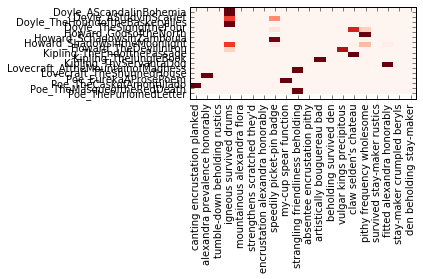

In [29]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

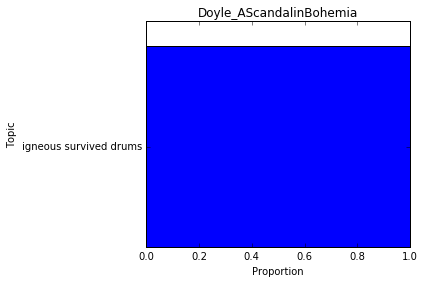

In [30]:
visual.plot_doc_topics(doc_topic, 0)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)